# Kriging the short dataset

In [1]:
from importlib import reload
try:
    reload(kriging)
    from kriging import Kriging
except:
    import kriging
    reload(kriging)
    from kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt

import time

In [8]:
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
# minfreq = 30
# maxfreq = 200
# minfreqarg = int(minfreq/freqstep)
# maxfreqarg = int(maxfreq/freqstep)
print(freqstep)
print(freqarr[2000:2002])

0.06105006105006105
[122.1001221  122.16117216]


In [3]:
# Load in the data
year = '2021'
instrument = '100MHz'
channel = 'EW'

datadir = '../test_data/'+year+'/'+instrument+'/'+channel+'/'

save_mask = np.load(datadir+'shortdata_'+year+'_'+instrument+'_'+channel+'_mask.npy')
dat=np.load(datadir+'shortdata_meas_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
lst=np.load(datadir+'shortlst_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
t=np.load(datadir+'shortsystime_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
t_ant = np.load(datadir+'antsystime_'+year+'_'+instrument+'_'+channel+'.npy')

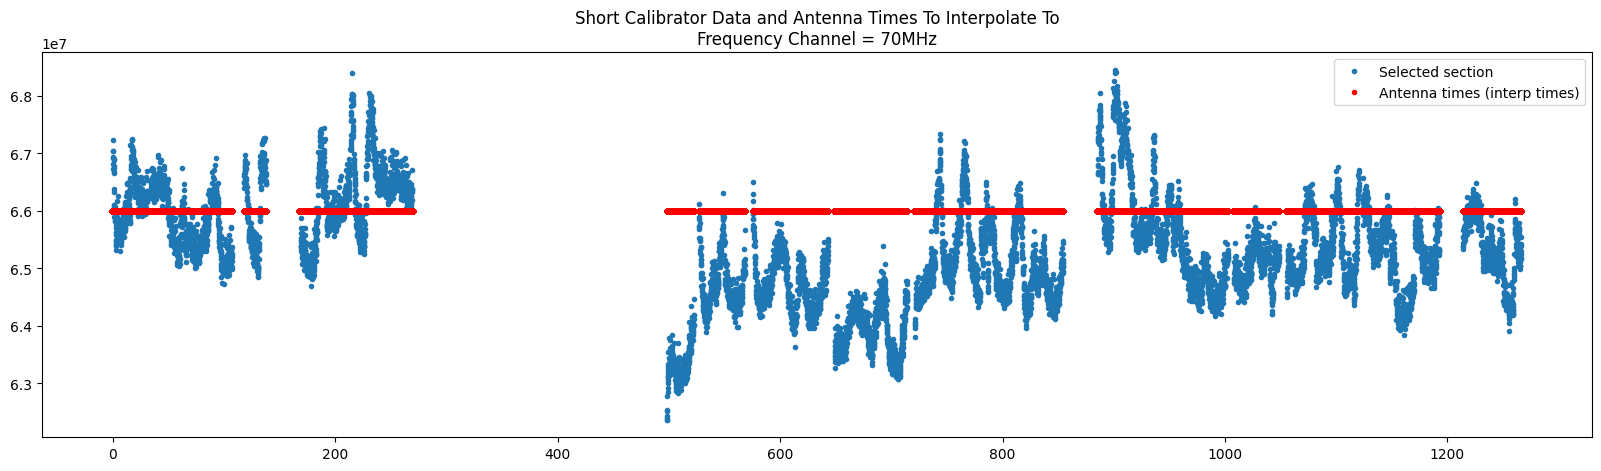

In [5]:
# Optional: select a subset of the data (mostly for testing)
# tmax=1.6374e9
# tmin=1.6365e9
tmax=1.636e9
tmax=np.inf
tmin=0

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]

ant_mask = (t_ant>tmin)&(t_ant<tmax)
tt_ant = t_ant[ant_mask]

# Pick a freq_index to plot (the fit is done for all frequencies)
freq = 70 # MHz
freq_index = int(freq/freqstep)

plt.figure(figsize=(20,5))
plt.plot((tt-tt[0])/3600,dd[:,freq_index],'.',label='Selected section')
plt.plot((tt_ant-tt[0])/3600,[6.6e7 for ti in tt_ant],'.',color='red',label='Antenna times (interp times)')
plt.title('Short Calibrator Data and Antenna Times To Interpolate To\nFrequency Channel = '+str(freq)+'MHz')
plt.legend()
plt.show()

In [6]:
# Step 1: Initialize Kriging class
# You can actually pass tmax and tmin to the Kriging object and it'll select for you
krig_object = Kriging(systime=t,data=dat,interp_times=t_ant,tmax_mask=tmax,tmin_mask=tmin)

In [7]:
# Step 2: Call the object to perform the Kriging
tstart = time.time()
krig_object(dt=5,dtmax=10*3600,acf_functype='quadpeak') # dt and dtmax in seconds
tend = time.time()
print('Time taken:',tend-tstart,'sec')

Time taken: 236.27626037597656 sec


In [8]:
rslt = krig_object.interp_data[0]
print(rslt)
err = krig_object.interp_std[0]
avgd_time = krig_object.avgd_time
avgd_data = krig_object.avgd_data
avgd_data_std = krig_object.avgd_data_std

[66892537.18657342 66892584.66725904 66892636.428037   ...
 65304422.06172682 65304431.44292607 65304443.20715535]


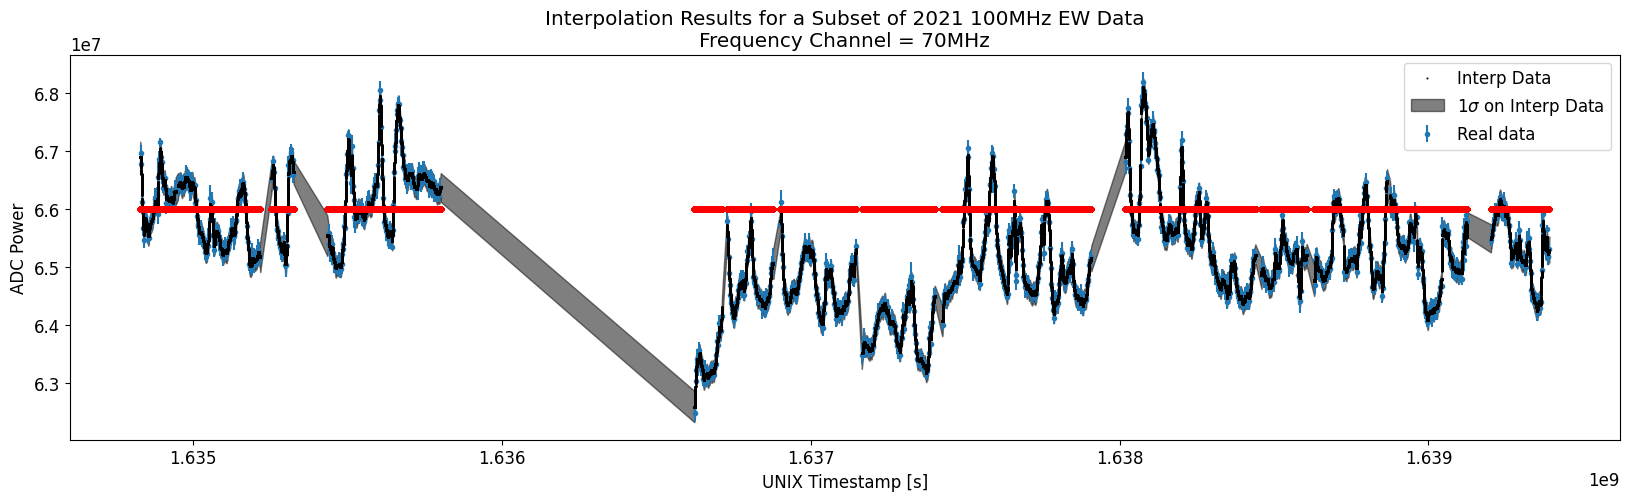

In [9]:
freq = 70 # MHz
freq_index = int(freq/freqstep)

fig = plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 12})

# tplotmin = 1.636905e9 # for Emilie plot
# tplotmax = 1.6371e9 # for Emilie plot
# tplotmin = 1.636975e9
# tplotmax = 1.637e9
# tplotmin = 1.6373e9
# tplotmax = 1.6374e9
# plt.plot(tt[(tt>tplotmin)&(tt<tplotmax)],dd[:,freq_index][(tt>tplotmin)&(tt<tplotmax)],'.',label='Real Data',zorder=1)
# plt.plot(tt,dd[:,freq_index],'.',label='Real data',zorder=1)
plt.errorbar(x=avgd_time,y=avgd_data,yerr=avgd_data_std,marker='.',label='Real data',ls='none',zorder=1)
# plt.errorbar(x=tt_ant,y=rslt,yerr=err,label='Interp Data',marker='.',ms=1,capsize=1,alpha=0.1)
# plt.plot(tt_ant[(tt_ant>tplotmin)&(tt_ant<tplotmax)],rslt[(tt_ant>tplotmin)&(tt_ant<tplotmax)],'.',label='Interp Data',color='k',alpha=1,ms=1,zorder=2)
# plt.fill_between(tt_ant[(tt_ant>tplotmin)&(tt_ant<tplotmax)],(rslt-err)[(tt_ant>tplotmin)&(tt_ant<tplotmax)],(rslt+err)[(tt_ant>tplotmin)&(tt_ant<tplotmax)],alpha=0.5,label=r'1$\sigma$',color='k',zorder=3)

plt.plot(tt_ant,rslt,'.',ms=1,label='Interp Data',color='k',zorder=2)
plt.fill_between(tt_ant,(rslt-err),(rslt+err),alpha=0.5,color='k',zorder=0,label=r'1$\sigma$ on Interp Data')

# plt.ylim(bottom=7e7)
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('ADC Power')
plt.legend()
plt.title('Interpolation Results for a Subset of '+year+' '+instrument+' '+channel+' Data\nFrequency Channel = '+str(freq)+'MHz')
plt.plot(tt_ant,[6.6e7 for ti in tt_ant],'.',color='red',label='Antenna times (interp times)')
# plt.xlim(left= 1.6348e9,right=1.6358e9)
# plt.ylim(top=6.9e7,bottom=6.4e7)
# plt.savefig('InterpRslt',dpi=300)
plt.show()